# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [7]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [151]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [152]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [153]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

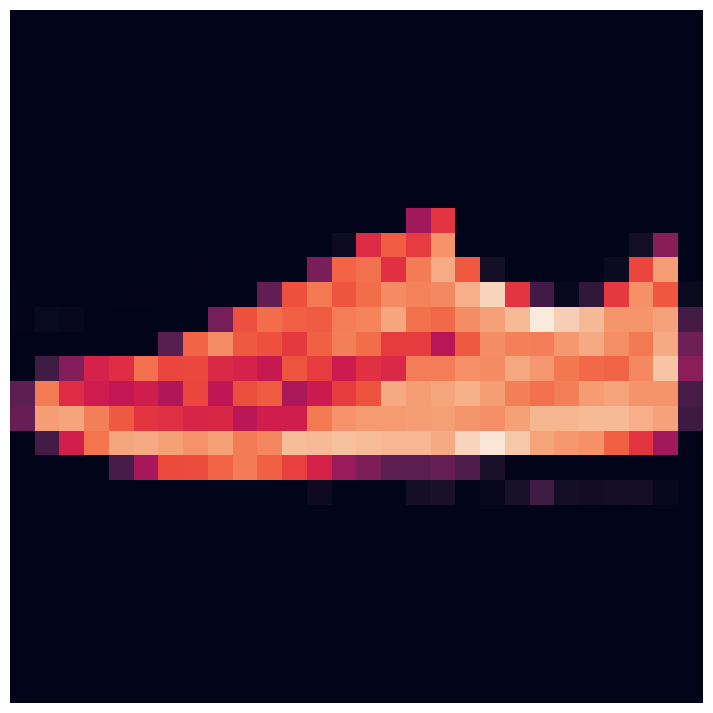

In [154]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

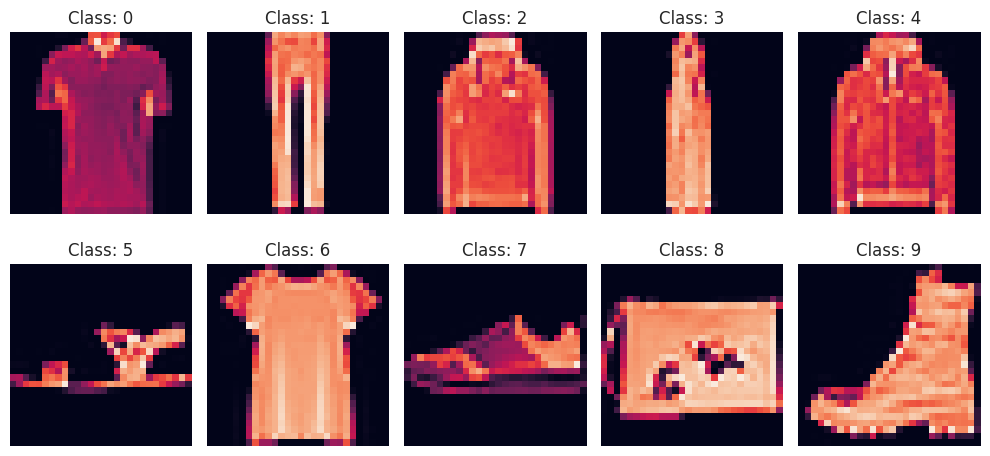

In [155]:
np.random.seed(42)
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X_subsample = X[idx_to_stay]
y_subsample = y[idx_to_stay]
unique_classes = np.unique(y_subsample)
indices_for_classes = []
for cls in unique_classes:
    idx = np.where(y_subsample == cls)[0][0]
    indices_for_classes.append(idx)
plt.figure(figsize=(10, 5))
for i, idx in enumerate(indices_for_classes, 1):
    plt.subplot(2, 5, i)
    image = X_subsample[idx].reshape(28, 28)
    plt.imshow(image)
    plt.title(f'Class: {y_subsample[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

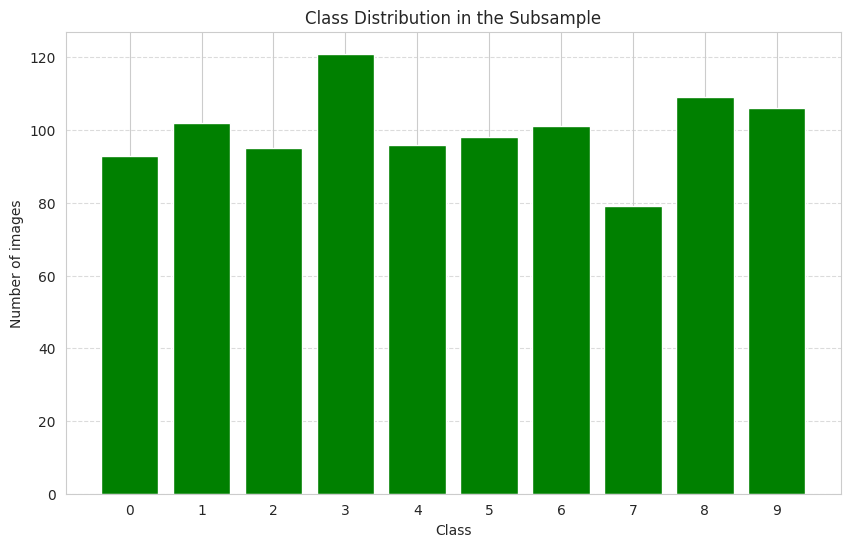

[ 93 102  95 121  96  98 101  79 109 106]
   Class  Count  Percentage
0      3    121        12.1
1      8    109        10.9
2      9    106        10.6
3      1    102        10.2
4      6    101        10.1
5      5     98         9.8
6      4     96         9.6
7      2     95         9.5
8      0     93         9.3
9      7     79         7.9


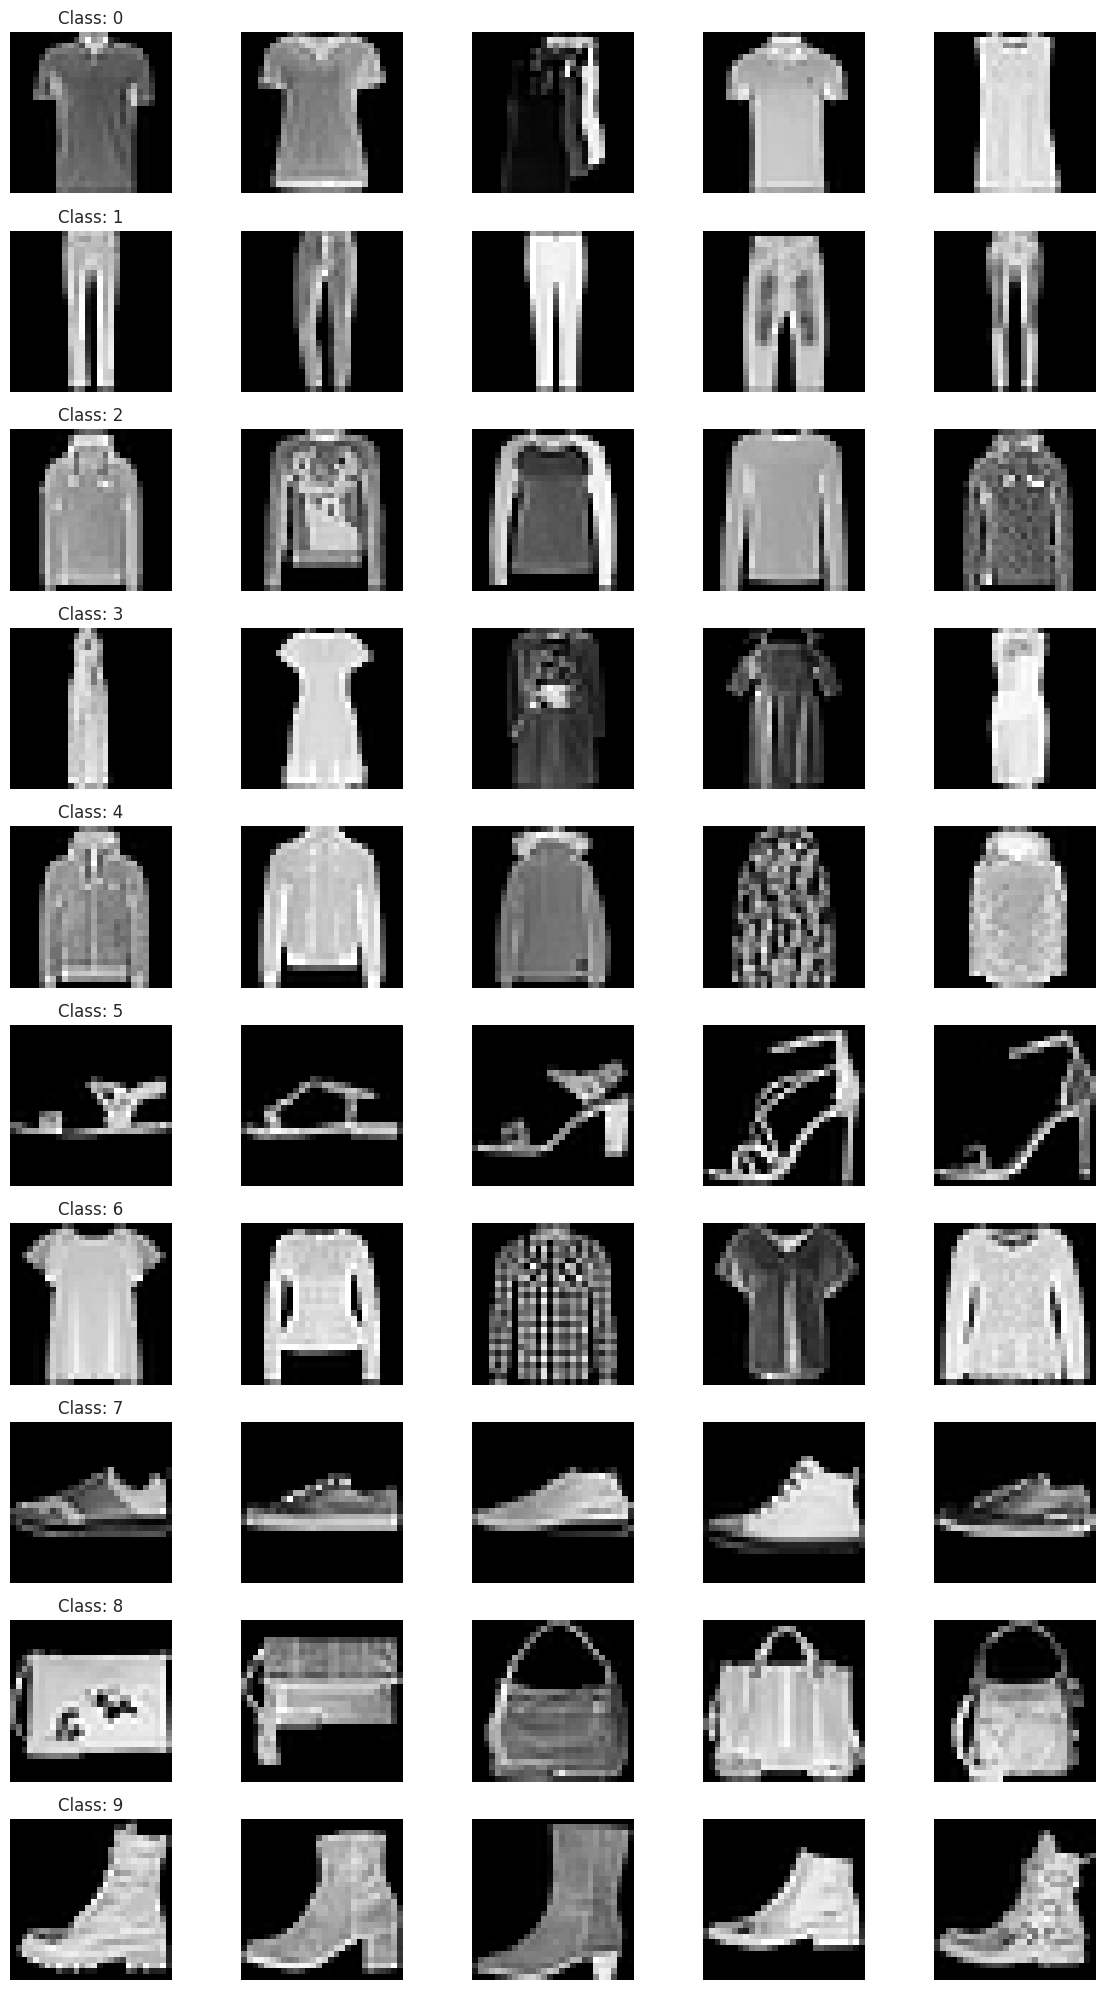

In [156]:
# 1.Визуализация распределения классов
y_subsample_int = y_subsample.astype(int)
## Подсчет количества изображений в каждом классе
class_counts = np.bincount(y_subsample_int)
## Визуализация распределения классов
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_counts)), class_counts, color = 'green')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Subsample')
plt.xticks(range(len(class_counts)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(class_counts)
# 2.Анализ распределения классов с подробностями
df = pd.DataFrame({
    'Class': y_subsample_int
})
class_distribution = df['Class'].value_counts().reset_index()
class_distribution.columns = ['Class', 'Count']
class_distribution['Percentage'] = (class_distribution['Count'] / class_distribution['Count'].sum()) * 100
print(class_distribution)
# 3.Визуализация нескольких изображений для каждого класса
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(12, 20))
axes = axes.ravel()
for i in range(10):
    samples = X_subsample[y_subsample_int == i][:5]
    for j in range(5):
        axes[i*5 + j].imshow(samples[j].reshape(28, 28), cmap='gray')
        axes[i*5 + j].axis('off')
        if j == 0:
            axes[i*5 + j].set_title(f'Class: {i}')
plt.tight_layout()
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [157]:
# Задаем начальное значение для генератора случайных чисел
SEED = 111
np.random.seed(SEED)
# Разделяем данные на тренировочную и тестовую выборки
# Размер тестовой выборки устанавливаем 20% от всего датасета
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
# Выводим размеры полученных выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 784), (200, 784), (800,), (200,))

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [161]:
# Убедимся, что y_subsample содержит целые числа
y_subsample_int = y_subsample.astype(int)
print(y_subsample_int)
# Получение индексов образцов с метками классов 0 и 1
binary_indices = np.where((y_subsample_int == 0) | (y_subsample_int == 1))[0]
# Создание подвыборок только с объектами классов 0 и 1
X_binary = X_subsample[binary_indices]
y_binary = y_subsample_int[binary_indices]  # Метки уже преобразованы в целые числа
# Разделение данных на тренировочную и тестовую выборки
binary_train_X, binary_test_X, binary_train_y, binary_test_y = train_test_split(
    X_binary, y_binary, train_size=0.7, test_size=0.3, random_state=42
)
print(f"Размер тренировочной выборки: {binary_train_X.shape[0]} образцов")
print(f"Размер тестовой выборки: {binary_test_X.shape[0]} образцов")

[7 3 9 3 5 0 5 7 1 9 4 0 9 5 4 2 9 9 9 8 8 5 5 9 2 6 8 8 9 3 2 3 0 4 8 8 4
 3 2 0 5 1 2 7 9 1 7 2 1 3 5 5 1 7 0 2 2 5 7 2 3 1 6 2 6 2 6 2 3 5 4 4 1 3
 9 4 3 6 6 7 5 2 6 2 0 3 8 9 2 9 6 3 4 9 6 6 6 4 3 5 2 5 2 0 5 7 7 8 5 6 2
 4 7 0 8 5 9 1 4 2 0 2 2 8 6 8 5 5 8 7 2 3 4 1 8 3 0 0 9 1 2 6 4 1 2 3 8 3
 9 7 8 0 7 7 6 6 6 0 4 2 1 0 6 4 9 1 4 9 1 6 8 9 3 2 5 6 9 5 8 0 2 7 3 5 3
 3 3 7 2 3 3 8 4 3 2 0 0 5 7 6 1 2 1 8 3 7 9 5 4 5 8 6 2 9 4 5 0 4 8 2 1 5
 8 7 1 0 5 4 8 7 1 2 5 5 2 0 4 7 6 6 3 1 0 1 6 3 7 6 8 8 0 5 9 1 2 0 4 5 0
 1 5 9 7 5 3 9 0 8 1 4 9 4 5 9 3 9 6 9 0 6 2 8 3 5 2 3 0 0 3 1 4 3 2 6 8 1
 5 8 9 7 2 5 0 6 2 8 8 3 1 1 6 6 7 8 8 8 9 5 8 1 1 4 6 9 1 2 2 8 4 9 7 2 3
 5 5 4 2 2 4 1 7 8 9 3 7 6 3 3 4 0 3 7 3 5 1 3 6 9 2 6 3 2 6 1 5 2 4 3 4 2
 3 7 9 4 3 0 0 6 5 7 9 8 5 6 2 0 5 3 9 8 4 4 3 0 6 8 1 3 6 4 9 8 8 7 0 8 1
 6 0 9 1 3 7 3 0 3 2 4 5 6 6 5 4 5 3 1 8 7 8 6 9 8 8 1 8 2 3 3 6 8 1 2 2 4
 0 0 8 3 2 0 1 3 6 4 5 2 1 6 8 4 5 9 2 7 4 5 8 1 9 0 7 8 0 7 9 1 9 8 4 4 7
 9 9 3 9 9 3 8 1 2 6 7 9 

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [288]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

Тут есть верификация, это специально, так как на 7 часов застряла на этом моменте и не могла понять, что именно идет не так

In [264]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
print (dists)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Начало выполнения метода compute_distances_two_loops
Обработка тестового образца 1 из 59
Расстояние от тестового образца 0 до первого тренировочного образца: 27956.0
Расстояние от тестового образца 1 до первого тренировочного образца: 23785.0
Расстояние от тестового образца 2 до первого тренировочного образца: 38434.0
Расстояние от тестового образца 3 до первого тренировочного образца: 28112.0
Расстояние от тестового образца 4 до первого тренировочного образца: 42696.0
Расстояние от тестового образца 5 до первого тренировочного образца: 25480.0
Расстояние от тестового образца 6 до первого тренировочного образца: 35754.0
Расстояние от тестового образца 7 до первого тренировочного образца: 52672.0
Расстояние от тестового образца 8 до первого тренировочного образца: 40731.0
Расстояние от тестового образца 9 до первого тренировочного образца: 37795.0
Обработка тестового образца 11 из 59
Расстояние от тестового образца 10 до первого тренировочного образца: 40733.0
Расстояние от тестового об

In [260]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [261]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [168]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

Выходные данные были обрезаны до нескольких последних строк (5000).
Расстояние от тестового образца 24 до первого тренировочного образца: 34199.0
Расстояние от тестового образца 25 до первого тренировочного образца: 43792.0
Расстояние от тестового образца 26 до первого тренировочного образца: 44074.0
Расстояние от тестового образца 27 до первого тренировочного образца: 41169.0
Расстояние от тестового образца 28 до первого тренировочного образца: 30339.0
Расстояние от тестового образца 29 до первого тренировочного образца: 28763.0
Обработка тестового образца 31 из 59
Расстояние от тестового образца 30 до первого тренировочного образца: 36672.0
Расстояние от тестового образца 31 до первого тренировочного образца: 35500.0
Расстояние от тестового образца 32 до первого тренировочного образца: 37882.0
Расстояние от тестового образца 33 до первого тренировочного образца: 26407.0
Расстояние от тестового образца 34 до первого тренировочного образца: 42825.0
Расстояние от тестового образца 35 до

Реализуем метод для предсказания меток класса

In [289]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_train_X).astype(int)
prediction

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [283]:
# TODO: binary_classification_metrics in metrics.py

In [295]:
binary_classification_metrics(136, 59)

(nan, nan, nan, nan)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [302]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [303]:
# Инициализация и обучение KNeighborsClassifier из sklearn
knn_sklearn = KNeighborsClassifier(n_neighbors=1)
knn_sklearn.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
predictions_sklearn = knn_sklearn.predict(X_test)

# Вычисление метрик с использованием функций из sklearn
precision_sklearn = precision_score(binary_test_y, predictions_sklearn)
recall_sklearn = recall_score(binary_test_y, predictions_sklearn)
accuracy_sklearn = accuracy_score(binary_test_y, predictions_sklearn)
f1_sklearn = f1_score(binary_test_y, predictions_sklearn)

print("Precision (sklearn):", precision_sklearn)
print("Recall (sklearn):", recall_sklearn)
print("Accuracy (sklearn):", accuracy_sklearn)
print("F1 Score (sklearn):", f1_sklearn)

ValueError: Expected 2D array, got 1D array instead:
array=[144 150 280 125  59  65 281 277 167  90  72 178  88 270 101 197  97  53
  71 262  52 102 166 189 173 220 206  97  60  61 242 121 128 104 265 132
 283 174 129 257 137  63  93 232 208 261 179 258 262  51 237  71 139 268
  69 317 249 154 192 116  81 122 259 191 292  55 107 210  91 253  85 252
  59  78 200  78 245 175  42 127  53  94 104 199 265 281 248 257 215 303
 170  59 277 209 138 198 124  96 288 225 265 101  55 198  51 252  64 220
 131 212 142 103 155 121  86 111  65 131  51 128 141  48 109 178  88  84
 216 150  60  96 190  74 279 182 160 245 276 174 180 150 196 138  97 246
 321 308 109  69 182 258 161 178 214  45 150 160  55 197 185 268 310 123
  68  72 185 144 147 168 178 246 151 127  83 332 152 109  90  66 214  85
 129  89 259 229 200  77  54  31 109 206 144 118  83 242 259  72 163 181
 141  71 137 195 179 102 131  47 235  77 198  93 162 225 275 183 306  81
  55 146 196 230 310  40 135 346  43 128  77 235  49  74  92  84 263 144
 142 341 115 158 273  85  88 220  39  80 172 217 336  52 272 115 110 131
  71 275 118  25 100 281 221 248 200 132  91  67 202  73  85 275 243  66
 293 236 243  87  39 217  92 296 292 142  50  53 104  75 120 142 143  99
  65 116 233 164  95  59 139 145 177 185  97  42 201 241  70  78  49 103
  44 111 191  47 182  58 155 151  79 104 143 152 170  75 200 124  91  49
 163  53 283 178 219 200 113 113  63 114 126 274  88 311  83  71 134 244
  65 173  57  68 141 270 134 202 148  64 302].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [190]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    train_metrics = []
    test_metrics = []
    for k in params:
        knn = KNNClassifier(k=k)
        knn.fit(X_train, y_train)
        # Предсказание на тренировочном наборе и вычисление метрики
        y_pred_train = knn.predict(X_train)
        train_metric = metric(y_pred_train, y_train)
        train_metrics.append(train_metric)
        # Предсказание на тестовом наборе и вычисление метрики
        y_pred_test = knn.predict(X_test)
        test_metric = metric(y_pred_test, y_test)
        test_metrics.append(test_metric)
    return train_metrics, test_metrics
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

In [188]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

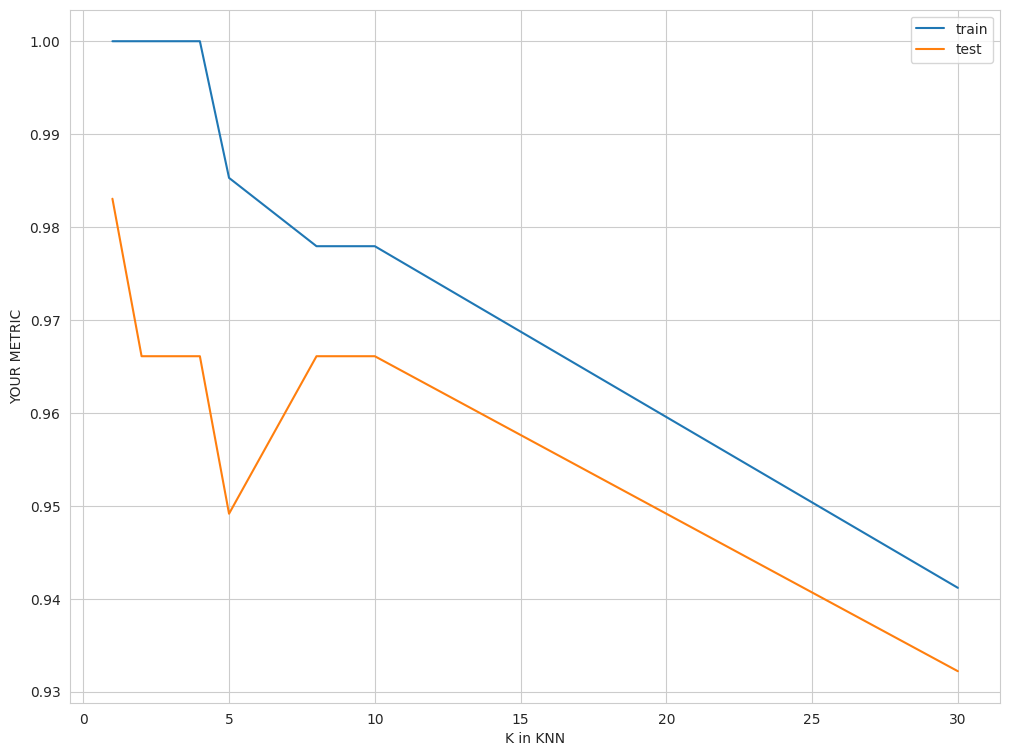

In [186]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [299]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

InvalidIndexError: (slice(None, None, None), None, slice(None, None, None))

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [75]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

NameError: name 'predictions' is not defined

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [238]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [239]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [240]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

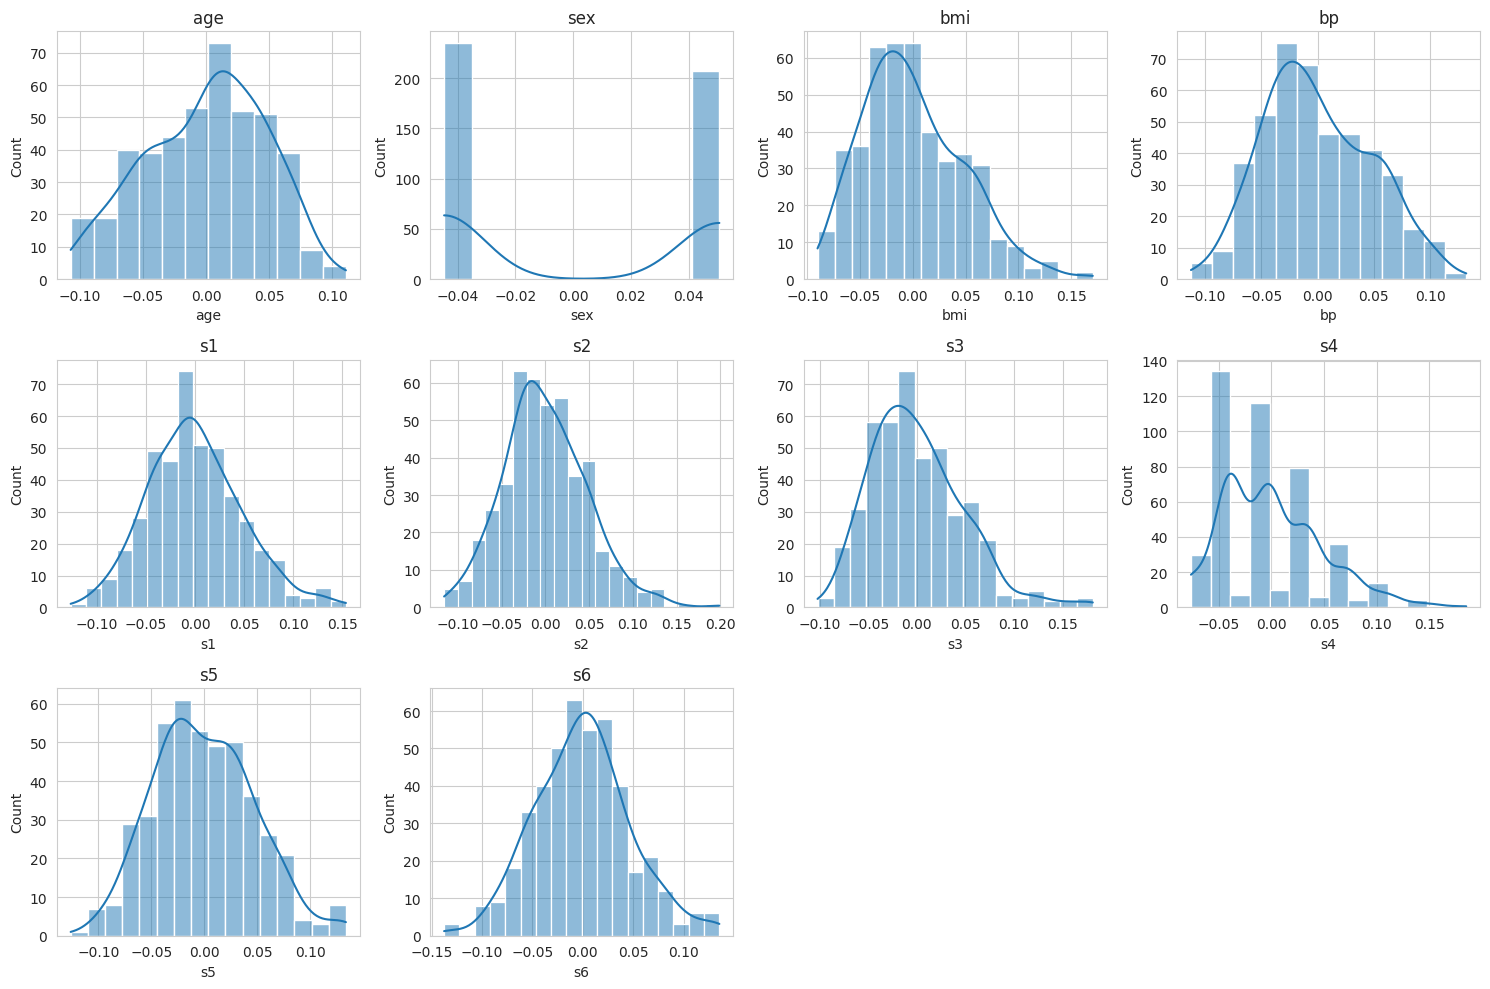

(                age           sex           bmi            bp            s1  \
 count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
 mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
 std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
 min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
 25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
 50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
 75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
 max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   
 
                  s2            s3            s4            s5            s6  
 count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  
 mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17  
 std    4.761905e-02  4.761905e-02  4.761

In [241]:
from sklearn.pipeline import Pipeline
# EDA
# Основные статистические показатели признаков
X_describe = X.describe()
# Проверка на наличие пропущенных значений
missing_values = X.isnull().sum()
# Визуализация распределений признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(X[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()
X_describe, missing_values

[125.6 160.2 153.  238.  153.4 150.4 246.2 170.   94.4 104.6 104.  151.6
 104.  166.6  61.4 105.4 263.8 252.  173.6 215.4 161.   86.6 106.6 184.6
 158.2 168.  196.6 145.6  67.6 117.2 158.  166.6  86.4 158.4 166.4 243.6
  73.8 136.8 148.6 106.6  90.  100.6 134.2 147.6 193.4  81.6  83.6  90.8
  84.4 119.2 117.8  88.2 150.6 112.  210.2 130.8  79.4 175.8 113.4  73.
 155.  117.6  58.   94.6 169.4 196.8 214.4 146.4 145.2 111.4 119.2 195.
 204.4  98.6 107.8 192.4 151.  163.6 210.4 218.2 150.8 139.   67.4  82.4
 105.4 113.2 110.4  84.2 159.2]
0.42480887066066253 42.777528089887646 3047.449887640449


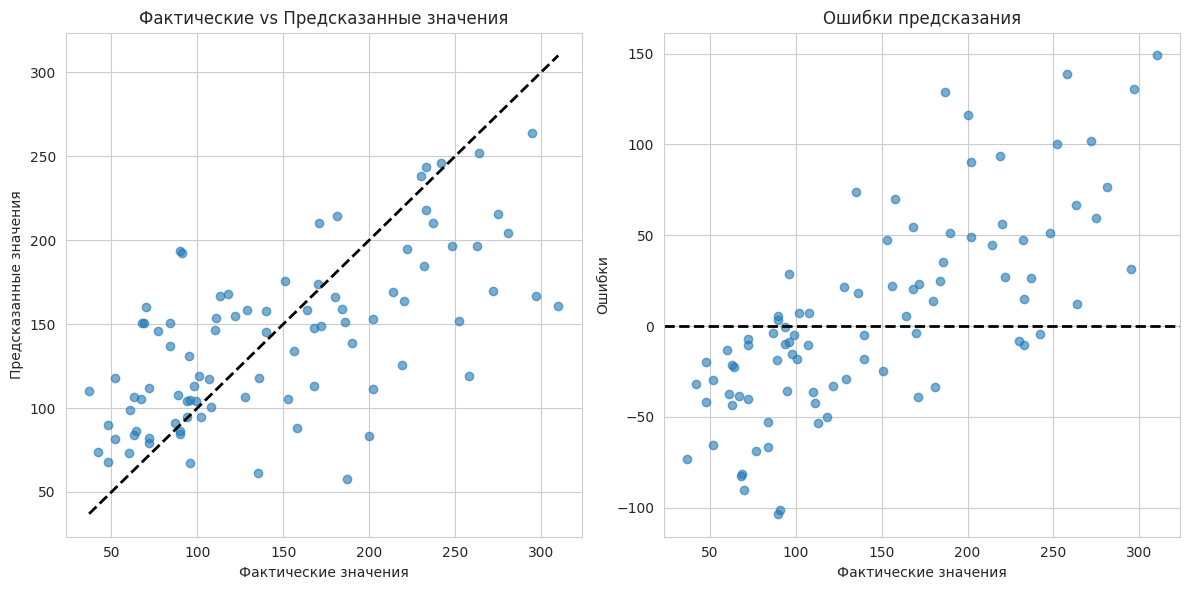

In [242]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Шаг стандартизации
    ('knn', KNeighborsRegressor())  # Шаг обучения модели KNN
])
# Обучение пайплайна на обучающих данных
pipeline.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)
print(y_pred)
# Оценка модели
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r2, mae, mse)
plt.figure(figsize=(12, 6))
# График рассеивания фактических vs предсказанных значений
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Линия идеального предсказания
plt.title('Фактические vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
# График ошибок предсказания
plt.subplot(1, 2, 2)
errors = y_test - y_pred
plt.scatter(y_test, errors, alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Линия нулевой ошибки
plt.title('Ошибки предсказания')
plt.xlabel('Фактические значения')
plt.ylabel('Ошибки')
plt.tight_layout()
plt.show()

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на тренировочных данных и сделайте предсказания.

In [243]:
# Создание модели KNeighborsRegressor
knn_model = KNeighborsRegressor()
# Обучение модели на обучающих данных
knn_model.fit(X_train, y_train)
# Выполнение предсказаний на тестовых данных
y_pred_knn = knn_model.predict(X_test)
print(y_pred_knn)

[125.6 160.2 153.  238.  153.4 150.4 246.2 170.  106.6 104.6  93.2 151.6
 104.  166.6  61.4 105.4 263.8 252.  173.6 215.4 184.6  86.6 106.6 174.
 158.2 168.  196.6 145.6  67.6 117.2 158.  166.6  89.  158.4 166.4 243.6
  73.8 136.8 148.6 106.6  90.  100.6 134.2 147.6 193.4  81.6  83.6  90.8
  84.4 119.2 117.8  88.2 150.6 112.  210.2 130.8  79.4 175.8 120.4  73.
 155.  117.6  58.   94.6 169.4 187.4 214.4 146.4 145.2 118.8 119.2 195.
 204.4  98.6 107.8 209.4 151.  163.6 210.4 218.2 150.8 139.   67.4  82.4
 105.4 113.2 110.4  84.2 159.2]


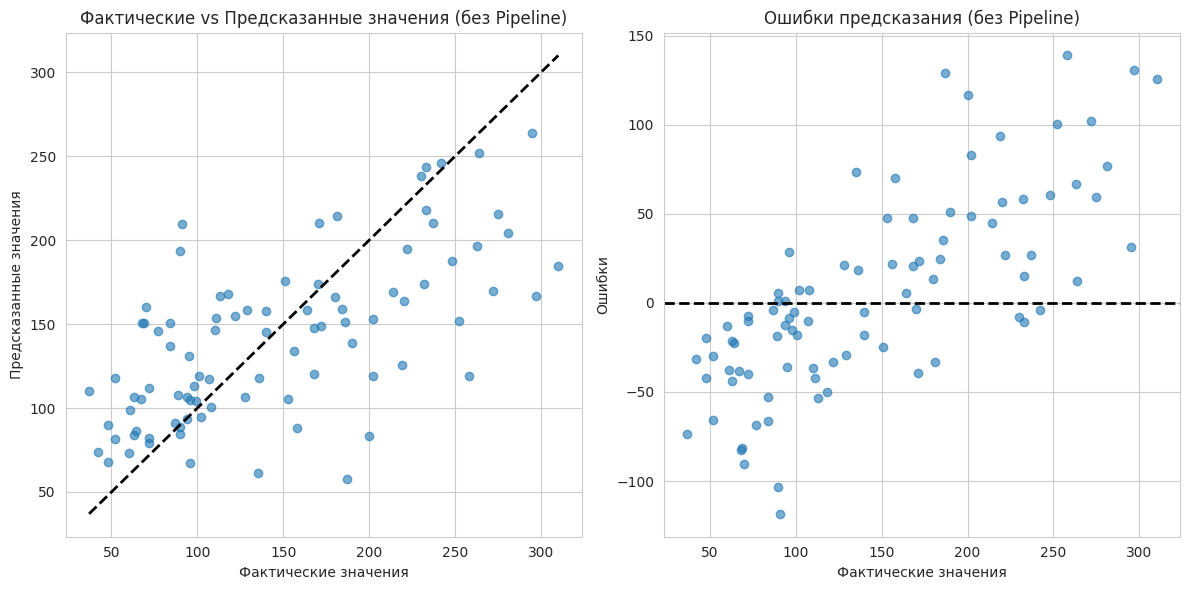

In [244]:
plt.figure(figsize=(12, 6))
# График рассеивания фактических vs предсказанных значений для модели без пайплайна
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Линия идеального предсказания
plt.title('Фактические vs Предсказанные значения (без Pipeline)')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
# График ошибок предсказания для модели без пайплайна
plt.subplot(1, 2, 2)
errors_knn = y_test - y_pred_knn
plt.scatter(y_test, errors_knn, alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Линия нулевой ошибки
plt.title('Ошибки предсказания (без Pipeline)')
plt.xlabel('Фактические значения')
plt.ylabel('Ошибки')
plt.tight_layout()
plt.show()

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [ ]:
# TODO: r_squared, mse, mae in metrics.py

In [246]:
from metrics import r_squared, mse, mae
r2_custom = r_squared(y_test, y_pred_knn)
mse_custom = mse(y_test, y_pred_knn)
mae_custom = mae(y_test, y_pred_knn)
r2_custom, mse_custom, mae_custom

(-0.28694000502710715, 3019.075505617978, 42.77078651685394)

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

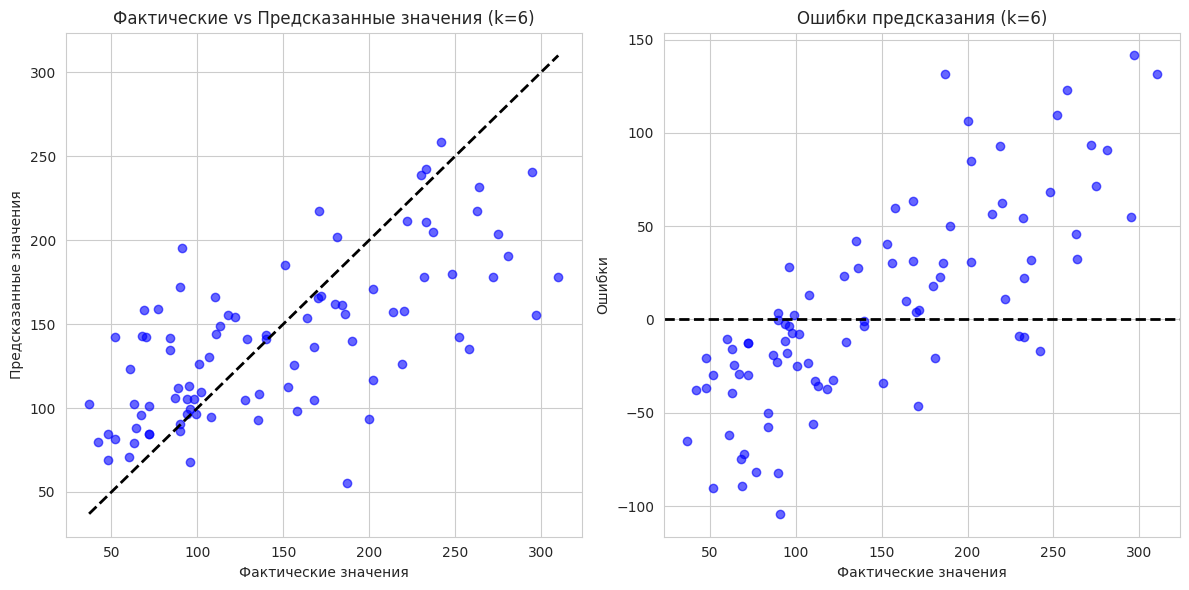

In [247]:
from metrics import r_squared, mse, mae
def find_best_k(X_train, y_train, X_test, y_test, k_values):
    test_mses = []
    for k in k_values:
        # Инициализация KNeighborsRegressor с текущим значением k
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        # Предсказание на тестовом наборе и вычисление MSE
        y_pred_test = knn.predict(X_test)
        test_mse = mse(y_test, y_pred_test)
        test_mses.append(test_mse)
    # Возвращаем список MSE для каждого k
    return test_mses
# Зададим диапазон значений k для поиска
k_values = range(1, 30)
# Вызываем функцию поиска лучшего k
test_mses = find_best_k(X_train, y_train, X_test, y_test, k_values)
# Находим k с минимальным MSE
best_k = k_values[np.argmin(test_mses)]
best_mse = min(test_mses)
best_k, best_mse
# Инициализация и обучение KNeighborsRegressor с оптимальным количеством соседей
knn_optimal = KNeighborsRegressor(n_neighbors=best_k)
knn_optimal.fit(X_train, y_train)
# Выполнение предсказаний на тестовом наборе данных
y_pred_optimal = knn_optimal.predict(X_test)
plt.figure(figsize=(12, 6))
# График рассеивания фактических vs предсказанных значений для оптимальной модели
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_optimal, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Линия идеального предсказания
plt.title(f'Фактические vs Предсказанные значения (k={best_k})')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
# График ошибок предсказания для оптимальной модели
plt.subplot(1, 2, 2)
errors_optimal = y_test - y_pred_optimal
plt.scatter(y_test, errors_optimal, alpha=0.6, color='blue')
plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Линия нулевой ошибки
plt.title(f'Ошибки предсказания (k={best_k})')
plt.xlabel('Фактические значения')
plt.ylabel('Ошибки')
plt.tight_layout()
plt.show()

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

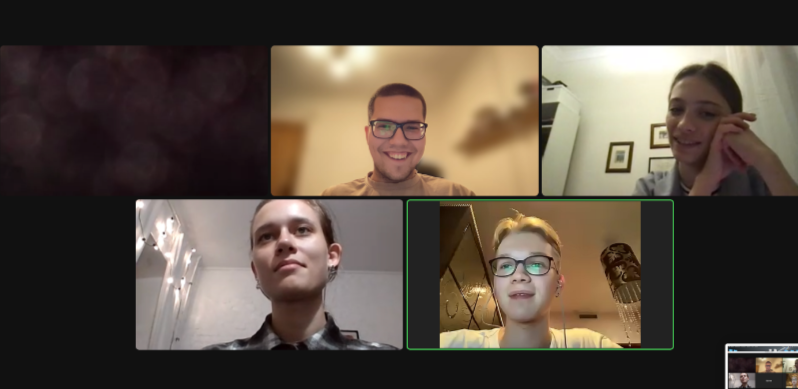![image.png]()

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Было очень сложно, ушло три дня по 6-8 часов, но все равно получилось слабо и криво